<a href="https://colab.research.google.com/github/Sensorzxc/Poker_SNA/blob/main/experiments_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0

In [3]:
!pip install torch_geometric

In [115]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from pathlib import Path
from typing import Dict, List

import torch

from torch_geometric.data import Data
from networkx.algorithms import community
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [116]:
class Action:
    def __init__(self, name: str, action_type: str, pos: str, value=0, pot_before=0):
        self.name = name
        self.action_type = action_type
        self.value = value
        self.pot_before = pot_before
        self.pos = pos


class Round:
    def __init__(self, board: list, actions: list[Action], pot=0):
        self.board = board
        self.actions = actions
        self.pot = pot


class Game:
    def __init__(self, rounds: List[Round], cards: dict[str, List], pot: float, changes: dict):
        self.rounds = rounds
        self.cards = cards
        self.changes = changes
        self.pot = pot


class Session:
    def __init__(self, games: List[Game]):
        self.games = games


class Stats:
    def __init__(self, cbet, calls, folds, bets, raises, checks, hands, vpm, tpfr, tbet3):
        self.raises = raises
        self.bets = bets
        self.cbet = cbet
        self.folds = folds
        self.calls = calls
        self.checks = checks
        self.hands = hands
        self.vpm = vpm
        self.tpfr = tpfr
        self.tbet3 = tbet3
        self.af = (bets + raises) / calls if calls > 0 else 0
        self.vpip = vpm / hands * 100 if hands > 0 else 0
        self.pfr = tpfr / hands * 100 if hands > 0 else 0
        self.bet3 = tbet3 / hands * 100 if hands > 0 else 0


sessions: List[Session] = []

In [117]:
def parse_game(game: List[str]) -> Game:
    rounds = []
    cards = {}
    pot = 150
    board = []
    changes = {}
    pos = {}
    if game[0] == '':
        game = game[1:]
    for i in range(2, 8):
        changes[game[i].split(' ')[2]] = 0
        pos[game[i].split(' ')[2]] = i - 2
    changes[game[8].split(':')[0]] += -50
    changes[game[9].split(':')[0]] += -100

    for i in range(11, 17):
        cards[game[i].split(' ')[2]] = [game[i].split(' ')[3][1:], game[i].split(' ')[4][:-1]]
    actions = []
    ind = 17
    while True:
        if game[ind][0] == '*' or game[ind].split(' ')[0] == 'Uncalled':
            break
        board = []
        if game[ind].split(':')[1].split(' ')[1] == 'folds' or game[ind].split(':')[1].split(' ')[1] == 'checks':
            actions.append(
                Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1], pot_before=pot,
                       pos=pos[game[ind].split(':')[0]]))
        elif game[ind].split(':')[1].split(' ')[1] == 'calls':
            actions.append(Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1],
                                  value=float(game[ind].split(':')[1].split(' ')[2]), pot_before=pot,
                                  pos=pos[game[ind].split(':')[0]]))
            changes[game[ind].split(':')[0]] += -float(game[ind].split(':')[1].split(' ')[2])
            pot += float(game[ind].split(':')[1].split(' ')[2])
        else:
            actions.append(Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1],
                                  value=float(game[ind].split(':')[1].split(' ')[4]), pot_before=pot,
                                  pos=pos[game[ind].split(':')[0]]))
            changes[game[ind].split(':')[0]] += -float(game[ind].split(':')[1].split(' ')[4])
            pot += float(game[ind].split(':')[1].split(' ')[4])
        ind += 1
    rounds.append(Round([], actions, pot))
    if game[ind].split(' ')[0] == 'Uncalled':
        changes[game[ind].split(' ')[-1]] += float(game[ind].split(' ')[2][1:-1])
        ind += 1
        actions.append(
            Action(name=game[ind].split(' ')[0], action_type='wins', value=float(float(game[ind].split(' ')[2])),
                   pot_before=pot, pos=pos[game[ind].split(' ')[0]]))
        changes[game[ind].split(' ')[0]] += float(float(game[ind].split(' ')[2]))
        ind += 2
        pot = float(game[ind].split(' ')[2])
        gm = Game(rounds, cards, pot, changes)
        return gm
    if '*** FLOP ***' in game[ind]:
        board = [game[ind].split(' ')[3][1:], game[ind].split(' ')[4], game[ind].split(' ')[5][:-1]]
        ind += 1
    actions = []
    while True:
        if game[ind][0] == '*' or game[ind].split(' ')[0] == 'Uncalled':
            break
        if game[ind].split(':')[1].split(' ')[1] == 'folds' or game[ind].split(':')[1].split(' ')[1] == 'checks':
            actions.append(
                Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1], pot_before=pot,
                       pos=pos[game[ind].split(':')[0]]))
        elif game[ind].split(':')[1].split(' ')[1] == 'calls' or game[ind].split(':')[1].split(' ')[1] == 'bets':
            actions.append(Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1],
                                  value=float(game[ind].split(':')[1].split(' ')[2]), pot_before=pot,
                                  pos=pos[game[ind].split(':')[0]]))
            changes[game[ind].split(':')[0]] += -float(game[ind].split(':')[1].split(' ')[2])
            pot += float(game[ind].split(':')[1].split(' ')[2])
        else:
            actions.append(Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1],
                                  value=float(game[ind].split(':')[1].split(' ')[4]), pot_before=pot,
                                  pos=pos[game[ind].split(':')[0]]))
            changes[game[ind].split(':')[0]] += -float(game[ind].split(':')[1].split(' ')[4])
            pot += float(game[ind].split(':')[1].split(' ')[4])
        ind += 1
    rounds.append(Round(board, actions, pot))
    if game[ind].split(' ')[0] == 'Uncalled':
        changes[game[ind].split(' ')[-1]] += float(game[ind].split(' ')[2][1:-1])
        ind += 1
        actions.append(
            Action(name=game[ind].split(' ')[0], action_type='wins', value=float(float(game[ind].split(' ')[2])),
                   pot_before=pot, pos=pos[game[ind].split(' ')[0]]))
        changes[game[ind].split(' ')[0]] += float(float(game[ind].split(' ')[2]))
        ind += 2
        pot = float(game[ind].split(' ')[2])
        gm = Game(rounds, cards, pot, changes)
        return gm
    if '*** TURN ***' in game[ind]:
        board.append(game[ind].split(' ')[6][1:-1])
        ind += 1
    actions = []
    while True:
        if game[ind][0] == '*' or game[ind].split(' ')[0] == 'Uncalled':
            break
        if game[ind].split(':')[1].split(' ')[1] == 'folds' or game[ind].split(':')[1].split(' ')[1] == 'checks':
            actions.append(
                Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1], pot_before=pot,
                       pos=pos[game[ind].split(':')[0]]))
        elif game[ind].split(':')[1].split(' ')[1] == 'calls' or game[ind].split(':')[1].split(' ')[1] == 'bets':
            actions.append(Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1],
                                  value=float(game[ind].split(':')[1].split(' ')[2]), pot_before=pot,
                                  pos=pos[game[ind].split(':')[0]]))
            changes[game[ind].split(':')[0]] += -float(game[ind].split(':')[1].split(' ')[2])
            pot += float(game[ind].split(':')[1].split(' ')[2])
        else:
            actions.append(Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1],
                                  value=float(game[ind].split(':')[1].split(' ')[4]), pot_before=pot,
                                  pos=pos[game[ind].split(':')[0]]))
            changes[game[ind].split(':')[0]] += -float(game[ind].split(':')[1].split(' ')[4])
            pot += float(game[ind].split(':')[1].split(' ')[4])
        ind += 1
    rounds.append(Round(board, actions, pot))
    if game[ind].split(' ')[0] == 'Uncalled':
        changes[game[ind].split(' ')[-1]] += float(game[ind].split(' ')[2][1:-1])
        ind += 1
        actions.append(
            Action(name=game[ind].split(' ')[0], action_type='wins', value=float(float(game[ind].split(' ')[2])),
                   pot_before=pot, pos=pos[game[ind].split(' ')[0]]))
        changes[game[ind].split(' ')[0]] += float(float(game[ind].split(' ')[2]))
        ind += 2
        pot = float(game[ind].split(' ')[2])
        gm = Game(rounds, cards, pot, changes)
        return gm
    if '*** RIVER ***' in game[ind]:
        board.append(game[ind].split(' ')[7][1:-1])
        ind += 1
    actions = []
    while True:
        while 'collected' in game[ind]:
            actions.append(
                Action(name=game[ind].split(' ')[0], action_type='collected',
                       value=float(float(game[ind].split(' ')[2])),
                       pot_before=pot, pos=pos[game[ind].split(' ')[0]]))
            changes[game[ind].split(' ')[0]] += float(float(game[ind].split(' ')[2]))
            ind += 1
            rounds.append(Round(board, actions, pot))
            gm = Game(rounds, cards, pot, changes)
            return gm
        if game[ind][0] == '*' or game[ind].split(' ')[0] == 'Uncalled':
            break
        if game[ind].split(':')[1].split(' ')[1] == 'folds' or game[ind].split(':')[1].split(' ')[1] == 'checks':
            actions.append(
                Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1], pot_before=pot,
                       pos=pos[game[ind].split(':')[0]]))
        elif game[ind].split(':')[1].split(' ')[1] == 'calls' or game[ind].split(':')[1].split(' ')[1] == 'bets':
            actions.append(Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1],
                                  value=float(game[ind].split(':')[1].split(' ')[2]), pot_before=pot,
                                  pos=pos[game[ind].split(':')[0]]))
            changes[game[ind].split(':')[0]] += -float(game[ind].split(':')[1].split(' ')[2])
            pot += float(game[ind].split(':')[1].split(' ')[2])
        else:
            actions.append(Action(name=game[ind].split(':')[0], action_type=game[ind].split(':')[1].split(' ')[1],
                                  value=float(game[ind].split(':')[1].split(' ')[4]), pot_before=pot,
                                  pos=pos[game[ind].split(':')[0]]))
            changes[game[ind].split(':')[0]] += -float(game[ind].split(':')[1].split(' ')[4])
            pot += float(game[ind].split(':')[1].split(' ')[4])
        ind += 1
    rounds.append(Round(board, actions, pot))
    if game[ind].split(' ')[0] == 'Uncalled':
        changes[game[ind].split(' ')[-1]] += float(game[ind].split(' ')[2][1:-1])
        ind += 1
        actions.append(
            Action(name=game[ind].split(' ')[0], action_type='wins', value=float(float(game[ind].split(' ')[2])),
                   pot_before=pot, pos=pos[game[ind].split(' ')[0]]))
        changes[game[ind].split(' ')[0]] += float(float(game[ind].split(' ')[2]))
        ind += 2
        pot = float(game[ind].split(' ')[2])
        gm = Game(rounds, cards, pot, changes)
        return gm
    if '*** SHOWDOWN ***' in game[ind]:
        ind += 1
    actions = []
    while 'shows' in game[ind]:
        actions.append(
            Action(name=game[ind].split(':')[0], action_type='shows', pot_before=pot, pos=pos[game[ind].split(':')[0]]))
        ind += 1
    while 'collected' in game[ind]:
        actions.append(
            Action(name=game[ind].split(' ')[0], action_type='collected', value=float(float(game[ind].split(' ')[2])),
                   pot_before=pot, pos=pos[game[ind].split(' ')[0]]))
        changes[game[ind].split(' ')[0]] += float(float(game[ind].split(' ')[2]))
        ind += 1
    rounds.append(Round(board, actions, pot))
    gm = Game(rounds, cards, pot, changes)
    return gm


def parse(path):
    with open(path) as f:
        session = []
        lines = f.read()
        all_games = lines.split('\n\n')
        for i in range(len(all_games)):
            game = all_games[i].split('\n')
            gm = parse_game(game)
            session.append(gm)
        sessions.append(Session(session))


def parse_all():
    path = '/content/pluribus_converted_logs'
    for file in os.listdir(path):
        parse(os.path.join(path, file))

In [118]:
all_players = []
stats = {}

def get_stats():
    for session in sessions:
        for game in session.games:
            for round in game.rounds:
                changed_h = []
                changed_a = []
                flag = False
                for action in round.actions:
                    if action.name not in stats:
                        stats[action.name] = Stats(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
                    if action.name not in changed_h:
                        stats[action.name].hands += 1
                        changed_h.append(action.name)
                    if action.action_type == 'bets' or action.action_type == 'raises' or action.action_type == 'calls':
                        if action.name not in changed_a:
                            stats[action.name].vpm += 1
                            changed_a.append(action.name)
                    if action.action_type == 'raises':
                        stats[action.name].raises += 1
                        if flag:
                            stats[action.name].tbet3 += 1
                        flag = True
                    elif action.action_type == 'bets':
                        stats[action.name].bets += 1
                    elif action.action_type == 'folds':
                        stats[action.name].folds += 1
                    elif action.action_type == 'calls':
                        stats[action.name].calls += 1
                    elif action.action_type == 'checks':
                        stats[action.name].checks += 1
                    if action.name not in all_players:
                        all_players.append(action.name)
        was = []
        for action in game.rounds[0].actions:
            if action.action_type == 'raises':
                was.append(action.name)
                stats[action.name].tpfr += 1

## 1

In [119]:
parse_all()
get_stats()

for stat in stats:
    print(stat)
    print('raises:', stats[stat].raises)
    stats[stat].af = (stats[stat].bets + stats[stat].raises) / stats[stat].calls
    print('bets:', stats[stat].bets)
    print('folds:', stats[stat].folds)
    print('calls:', stats[stat].calls)
    print('checks:', stats[stat].checks)
    print('af:', stats[stat].af)
    print('hands:', stats[stat].hands)
    print('vpm:', stats[stat].vpm)
    stats[stat].vpip = stats[stat].vpm / stats[stat].hands * 100
    print('vpip:', stats[stat].vpip)
    stats[stat].pfr = stats[stat].tpfr / stats[stat].hands * 100
    print('pfr:', stats[stat].pfr)
    stats[stat].bet3 = stats[stat].tbet3 / stats[stat].hands * 100
    print('bet3:', stats[stat].bet3)
    print('\n')

MrOrange
raises: 1158
bets: 670
folds: 6323
calls: 962
checks: 1652
af: 1.9002079002079002
hands: 10318
vpm: 2611
vpip: 25.305291723202174
pfr: 0.06784260515603799
bet3: 2.771855010660981


Hattori
raises: 261
bets: 153
folds: 1090
calls: 225
checks: 361
af: 1.84
hands: 1997
vpm: 604
vpip: 30.24536805207812
pfr: 0.20030045067601399
bet3: 1.7526289434151225


MrBlue
raises: 1865
bets: 1132
folds: 7096
calls: 2020
checks: 2902
af: 1.4836633663366336
hands: 13927
vpm: 4685
vpip: 33.63969268327709
pfr: 0.1364256480218281
bet3: 2.0392044230631146


Pluribus
raises: 1930
bets: 1197
folds: 8007
calls: 1621
checks: 2414
af: 1.9290561381863047
hands: 14320
vpm: 4467
vpip: 31.194134078212286
pfr: 0.09078212290502793
bet3: 2.541899441340782


Budd
raises: 488
bets: 291
folds: 2025
calls: 315
checks: 534
af: 2.473015873015873
hands: 3485
vpm: 1030
vpip: 29.555236728837876
pfr: 0.11477761836441894
bet3: 3.242467718794835


ORen
raises: 137
bets: 111
folds: 621
calls: 112
checks: 177
af: 2.214285714

In [120]:
# Конвертируем в DataFrame для удобства
stats_df = pd.DataFrame({
    player: {
        "raises": stat.raises,
        "bets": stat.bets,
        "folds": stat.folds,
        "calls": stat.calls,
        "checks": stat.checks,
        "hands": stat.hands,
        "vpm": stat.vpm,
        "af": stat.af,
        "vpip": stat.vpip,
        "pfr": stat.pfr,
        "bet3": stat.bet3
    } for player, stat in stats.items()
}).T
print(stats_df)

          raises    bets   folds   calls  checks    hands     vpm        af  \
MrOrange  1158.0   670.0  6323.0   962.0  1652.0  10318.0  2611.0  1.900208   
Hattori    261.0   153.0  1090.0   225.0   361.0   1997.0   604.0  1.840000   
MrBlue    1865.0  1132.0  7096.0  2020.0  2902.0  13927.0  4685.0  1.483663   
Pluribus  1930.0  1197.0  8007.0  1621.0  2414.0  14320.0  4467.0  1.929056   
Budd       488.0   291.0  2025.0   315.0   534.0   3485.0  1030.0  2.473016   
ORen       137.0   111.0   621.0   112.0   177.0   1106.0   341.0  2.214286   
Bill      1444.0   897.0  5298.0  1109.0  1600.0   9714.0  3215.0  2.110911   
MrWhite    819.0   453.0  3687.0   712.0  1128.0   6377.0  1862.0  1.786517   
Joe        295.0   165.0  1267.0   173.0   303.0   2093.0   596.0  2.658960   
MrPink    1182.0   770.0  4846.0   946.0  1390.0   8610.0  2698.0  2.063425   
Eddie     1085.0   751.0  4404.0   917.0  1425.0   8106.0  2596.0  2.002181   
MrBrown    233.0   149.0  1107.0   234.0   356.0   1

In [121]:
def create_hand_graph(players, actions, board_cards):
    """
    Создаёт граф раздачи, где вершины - игроки (с картами) и стадии, а рёбра - действия с величинами ставок.
    players: dict[str, str] - имена игроков и их карты.
    actions: list of tuples [(source, target, action, bet)] - действия в раздаче.
    board_cards: list[str] - карты на борде.
    """
    G = nx.DiGraph()

    # Вершины для игроков с их картами
    for player, cards in players.items():
        G.add_node(player, type="player", cards=cards)

    # Вершины для стадий игры с картами борда
    stages = ["pre-flop", "flop", "turn", "river"]
    for i, stage in enumerate(stages):
        stage_cards = " ".join(board_cards[: (i + 1) * 3]) if i > 0 else ""
        G.add_node(stage, type="stage", cards=stage_cards)

    # Рёбра для действий с указанием величины ставок
    for source, target, action, bet in actions:
        G.add_edge(source, target, action=action, bet=bet, type="edge")

    return G

def create_all_hand_graphs(sessions):
    all_graphs = []
    stages_d = {0: "pre-flop", 1: "flop", 2: "turn", 3: "river"}

    for session in sessions:
        for game in session.games:
            stages_i = 0
            actions = []
            players = {name: " ".join(cards) for name, cards in game.cards.items()}
            for round in game.rounds:
                for action in round.actions:
                    if action.action_type in ['bets', 'raises', 'calls', 'folds', 'checks']:
                        actions.append((action.name, stages_d[stages_i], action.action_type, action.value))
                stages_i += 1
            hand_graph = create_hand_graph(players, actions, game.changes.get("board", []))
            all_graphs.append(hand_graph)

    return all_graphs

### === Визуализация графа ===


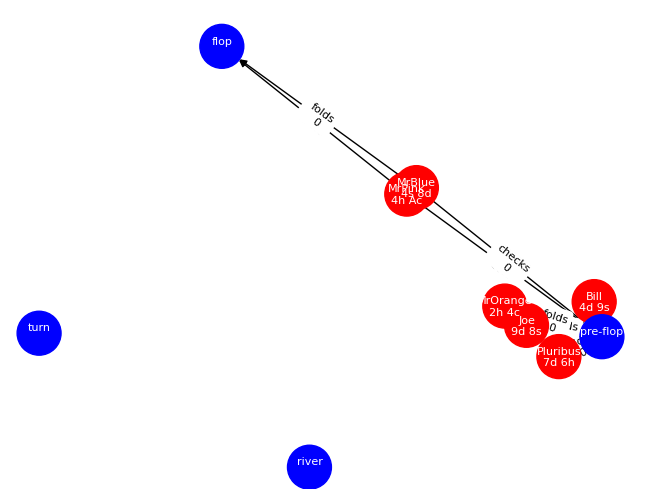

In [126]:
def plot_graph(G):
    """
    Визуализирует граф раздачи с учётом карт у вершин и величин ставок у рёбер.
    """
    pos = nx.spring_layout(G)  # Расположение узлов
    node_colors = [
        "red" if G.nodes[node]["type"] == "player" else "blue" for node in G.nodes
    ]
    node_labels = {
        node: f"{node}\n{G.nodes[node].get('cards', '')}" for node in G.nodes
    }

    # Отрисовка графа
    nx.draw(
        G, pos, with_labels=True, labels=node_labels, node_color=node_colors,
        node_size=1000, font_size=8, font_color="white"
    )

    # Добавление подписей рёбер (действие и ставка)
    edge_labels = {
        (u, v): f"{d['action']}\n{d.get('bet', 0)}"
        for u, v, d in G.edges(data=True)
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Показ графика
    plt.show()


all_hand_graphs = create_all_hand_graphs(sessions)
hand_graph = all_hand_graphs[240]
plot_graph(hand_graph)

### === Анализ графов ===


In [127]:
# Центральность по степеням (degree centrality)
centrality = nx.degree_centrality(hand_graph)
print("Центральность по степеням:", centrality)

# Поиск кластеров (community detection)
from networkx.algorithms import community
communities = community.greedy_modularity_communities(hand_graph)
print("Кластеры:", [list(c) for c in communities])


Центральность по степеням: {'MrPink': 0.2222222222222222, 'MrBlue': 0.2222222222222222, 'Joe': 0.1111111111111111, 'Bill': 0.1111111111111111, 'Pluribus': 0.1111111111111111, 'MrOrange': 0.1111111111111111, 'pre-flop': 0.6666666666666666, 'flop': 0.2222222222222222, 'turn': 0.0, 'river': 0.0}
Кластеры: [['pre-flop', 'Pluribus', 'Bill', 'Joe', 'MrOrange'], ['flop', 'MrPink', 'MrBlue'], ['turn'], ['river']]


### === Анализ игровых стилей ===


In [128]:
def analyze_player_style(stats):
    """
    Анализ игровых стилей на основе статистики.
    """
    for player, data in stats.items():
        print(f"Игрок: {player}")
        print(f"AF (Aggression Factor): {data.af:.2f}")
        print(f"VPIP (Voluntarily Put Money in Pot): {data.vpip:.2f}%")
        print(f"PFR (Pre-Flop Raise): {data.pfr:.2f}%")
        print(f"3-bet: {data.bet3:.2f}%")
        print("---")

analyze_player_style(stats)

Игрок: MrOrange
AF (Aggression Factor): 1.90
VPIP (Voluntarily Put Money in Pot): 25.31%
PFR (Pre-Flop Raise): 0.07%
3-bet: 2.77%
---
Игрок: Hattori
AF (Aggression Factor): 1.84
VPIP (Voluntarily Put Money in Pot): 30.25%
PFR (Pre-Flop Raise): 0.20%
3-bet: 1.75%
---
Игрок: MrBlue
AF (Aggression Factor): 1.48
VPIP (Voluntarily Put Money in Pot): 33.64%
PFR (Pre-Flop Raise): 0.14%
3-bet: 2.04%
---
Игрок: Pluribus
AF (Aggression Factor): 1.93
VPIP (Voluntarily Put Money in Pot): 31.19%
PFR (Pre-Flop Raise): 0.09%
3-bet: 2.54%
---
Игрок: Budd
AF (Aggression Factor): 2.47
VPIP (Voluntarily Put Money in Pot): 29.56%
PFR (Pre-Flop Raise): 0.11%
3-bet: 3.24%
---
Игрок: ORen
AF (Aggression Factor): 2.21
VPIP (Voluntarily Put Money in Pot): 30.83%
PFR (Pre-Flop Raise): 0.18%
3-bet: 2.89%
---
Игрок: Bill
AF (Aggression Factor): 2.11
VPIP (Voluntarily Put Money in Pot): 33.10%
PFR (Pre-Flop Raise): 0.16%
3-bet: 3.54%
---
Игрок: MrWhite
AF (Aggression Factor): 1.79
VPIP (Voluntarily Put Money in Po

### === Расширение анализа графов ===


In [129]:
# дополнительные меры центральности
betweenness = nx.betweenness_centrality(hand_graph)
closeness = nx.closeness_centrality(hand_graph)
print("Betweenness центральность:", betweenness)
print("Closeness центральность:", closeness)

# Поиск сообществ с помощью Louvain
from community import community_louvain
partition = community_louvain.best_partition(hand_graph.to_undirected())
print("Сообщества Louvain:", partition)

Betweenness центральность: {'MrPink': 0.0, 'MrBlue': 0.0, 'Joe': 0.0, 'Bill': 0.0, 'Pluribus': 0.0, 'MrOrange': 0.0, 'pre-flop': 0.0, 'flop': 0.0, 'turn': 0.0, 'river': 0.0}
Closeness центральность: {'MrPink': 0.0, 'MrBlue': 0.0, 'Joe': 0.0, 'Bill': 0.0, 'Pluribus': 0.0, 'MrOrange': 0.0, 'pre-flop': 0.6666666666666666, 'flop': 0.2222222222222222, 'turn': 0.0, 'river': 0.0}
Сообщества Louvain: {'MrPink': 3, 'MrBlue': 3, 'Joe': 2, 'Bill': 2, 'Pluribus': 2, 'MrOrange': 2, 'pre-flop': 2, 'flop': 3, 'turn': 0, 'river': 1}


### === Сводная таблица статистики игроков ===


In [130]:
def summarize_stats(stats):
    """
    Создаёт сводную таблицу с ключевыми метриками игроков.
    """
    summary = pd.DataFrame({
        player: {
            "AF": stat.af,
            "VPIP": stat.vpip,
            "PFR": stat.pfr,
            "3-bet": stat.bet3,
            "Hands": stat.hands,
            "Raises": stat.raises,
            "Bets": stat.bets,
            "Folds": stat.folds
        } for player, stat in stats.items()
    }).T
    return summary

summary_df = summarize_stats(stats)
print("Сводная таблица статистики игроков:\n", summary_df)

Сводная таблица статистики игроков:
                 AF       VPIP       PFR     3-bet    Hands  Raises    Bets  \
MrOrange  1.900208  25.305292  0.067843  2.771855  10318.0  1158.0   670.0   
Hattori   1.840000  30.245368  0.200300  1.752629   1997.0   261.0   153.0   
MrBlue    1.483663  33.639693  0.136426  2.039204  13927.0  1865.0  1132.0   
Pluribus  1.929056  31.194134  0.090782  2.541899  14320.0  1930.0  1197.0   
Budd      2.473016  29.555237  0.114778  3.242468   3485.0   488.0   291.0   
ORen      2.214286  30.831826  0.180832  2.893309   1106.0   137.0   111.0   
Bill      2.110911  33.096562  0.164711  3.541281   9714.0  1444.0   897.0   
MrWhite   1.786517  29.198683  0.172495  2.556061   6377.0   819.0   453.0   
Joe       2.658960  28.475872  0.047778  3.392260   2093.0   295.0   165.0   
MrPink    2.063425  31.335656  0.127758  3.286876   8610.0  1182.0   770.0   
Eddie     2.002181  32.025660  0.135702  2.146558   8106.0  1085.0   751.0   
MrBrown   1.632479  29.9046

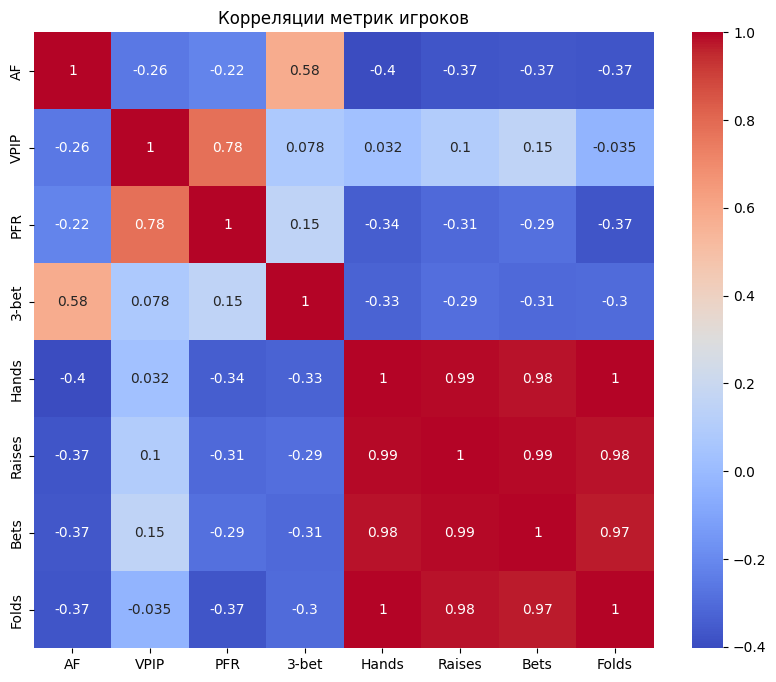

In [131]:
# Визуализация корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(summary_df.corr(), annot=True, cmap="coolwarm")
plt.title("Корреляции метрик игроков")
plt.show()

### 1. Классификация стилей игры
Для анализа графов и кластеризации стилей игрока:

Характеристики графов

Центральность игрока:
- Рассчитать степенную, близостную, и междуцентровую центральности игроков.

Средний размер ставок:
- Извлечь значения ставок (атрибуты рёбер) для каждого игрока и рассчитать средние значения.

Частота действий:
- Подсчитать количество raise, fold, check для каждого игрока.

In [132]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

def extract_features_from_graph(graphs):
    data = []
    for G in graphs:
        player_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "player"]
        for player in player_nodes:
            centrality = nx.degree_centrality(G).get(player, 0)
            bet_sizes = [
                d.get("bet", 0)
                for u, v, d in G.edges(data=True)
                if u == player or v == player
            ]
            avg_bet = np.mean(bet_sizes) if bet_sizes else 0
            actions = [d["action"] for u, v, d in G.edges(data=True) if u == player]
            raise_count = actions.count("raises")
            fold_count = actions.count("folds")
            check_count = actions.count("checks")
            data.append([centrality, avg_bet, raise_count, fold_count, check_count])
    return pd.DataFrame(data, columns=["centrality", "avg_bet", "raises", "folds", "checks"])

# Извлечение характеристик
features = extract_features_from_graph(all_hand_graphs)

# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features)

# Добавление меток кластеров
features["cluster"] = clusters
print(features.groupby("cluster").mean())


         centrality      avg_bet    raises     folds    checks
cluster                                                       
0          0.150702    48.457693  0.128260  0.830900  0.171393
1          0.111111  9070.926471  0.602941  0.000000  0.000000
2          0.273560  1559.363355  0.868605  0.039311  0.199246


Интерпретация кластеров

Кластер 0: Тайтовые игроки (много fold, минимальные ставки).

Кластер 1:  Агрессивные игроки (частые raise, большие ставки).

Кластер 2: Лузово-агрессивные (высокий raises, средние ставки).

### 2. Прогнозирование действий игроков
Использование временных графовых нейронных сетей (GNN):
Подготовка данных
- Построить последовательности графов для игр.
- Закодировать действия и метрики (ставки, стадии).

In [59]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

action_encoder = LabelEncoder()
action_encoder.fit(["bets", "raises", "calls", "folds", "checks", "other"])

def create_hand_graph(players, actions, board_cards):
    """
    Создаёт граф раздачи, где вершины - игроки (с картами) и стадии, а рёбра - действия с величинами ставок.
    players: dict[str, str] - имена игроков и их карты.
    actions: list of tuples [(source, target, action, bet)] - действия в раздаче.
    board_cards: list[str] - карты на борде.
    """
    G = nx.DiGraph()

    for player, cards in players.items():
        card_values = [ord(card[0]) for card in cards.split()]
        G.add_node(player, type=0, features=card_values)

    stages = ["pre-flop", "flop", "turn", "river"]
    for i, stage in enumerate(stages):
        stage_cards = board_cards[: (i + 1) * 3] if i > 0 else []
        card_values = [ord(card[0]) for card in stage_cards]
        G.add_node(stage, type=1, features=card_values)

    for source, target, action, bet in actions:
        bet_value = float(bet) if isinstance(bet, (int, float, str)) and str(bet).replace('.', '', 1).isdigit() else 0.0
        action_encoded = action_encoder.transform([action])[0]
        G.add_edge(source, target, action=action_encoded, bet=bet_value)

    return G


In [60]:
def create_all_hand_graphs(sessions):
    """
    Создаёт графы раздач для всех игр в сессиях.
    """
    all_graphs = []
    stages_d = {0: "pre-flop", 1: "flop", 2: "turn", 3: "river"}

    for session in sessions:
        for game in session.games:
            stages_i = 0
            actions = []
            players = {name: " ".join(cards) if isinstance(cards, list) else str(cards)
                       for name, cards in game.cards.items()}

            for round in game.rounds:
                for action in round.actions:
                    if action.action_type in ['bets', 'raises', 'calls', 'folds', 'checks']:
                        bet_value = action.value if isinstance(action.value, (int, float)) else 0.0
                        actions.append((action.name, stages_d[stages_i], action.action_type, bet_value))
                stages_i += 1

            board_cards = game.changes.get("board", []) if isinstance(game.changes.get("board", []), list) else []
            hand_graph = create_hand_graph(players, actions, board_cards)
            all_graphs.append(hand_graph)

    return all_graphs


In [61]:
all_hand_graphs = create_all_hand_graphs(sessions)

In [100]:
import torch
from torch_geometric.utils import from_networkx

def convert_graph_to_torch_geometric(G):
    """
    Конвертирует граф NetworkX в формат PyTorch Geometric.
    """
    node_to_index = {node: i for i, node in enumerate(G.nodes)}

    edge_index = torch.tensor(
        [[node_to_index[src], node_to_index[dst]] for src, dst in G.edges], dtype=torch.long
    ).t().contiguous()

    data = from_networkx(G)
    data.edge_index = edge_index

    node_features = []
    for _, node_data in G.nodes(data=True):
        if 'features' in node_data and node_data["type"] == 0:
            node_features.append(node_data['features'])
        else:
            node_features.append([0.0, 0.0])

    data.features = torch.tensor(node_features, dtype=torch.float)

    return data

torch_graphs = [convert_graph_to_torch_geometric(G) for G in all_hand_graphs]

In [101]:
from torch.nn import Module, Linear, LSTM
from torch_geometric.nn import GCNConv

class GCN_LSTM_Model(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN_LSTM_Model, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.lstm = LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        x = self.gcn1(x, edge_index)
        x = torch.relu(x)
        x = self.gcn2(x, edge_index)
        x = torch.relu(x)

        x = torch.stack([x[batch == b] for b in torch.unique(batch)])
        _, (hn, _) = self.lstm(x)

        out = self.fc(hn[-1])
        return out


In [133]:
import torch.optim as optim
import torch.nn.functional as F

input_dim = 14
hidden_dim = 64
output_dim = 5  # Классы действий (raise, call, fold, bet, check)

model = GCN_LSTM_Model(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()

        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(out, data.y)  # data.y - действия игроков (целевые метки)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")